### 解壓縮檔案&創造目錄

In [15]:
import os
import zipfile
import constant


#make directory
os.chdir('/kaggle/working/')
if not os.path.exists(constant.DATASET_DIR):
    os.makedirs(constant.DATASET_DIR)
    
if not os.path.exists(constant.OUTPUT_DIR):
    os.makedirs(constant.OUTPUT_DIR)
    
if not os.path.exists(constant.DATA_DIR):
    os.makedirs(constant.DATA_DIR)

#unzip dataset
if not os.path.exists('/kaggle/working/dataset/train'):
    zf = zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r')
    zf.extractall(constant.DATASET_DIR)
    zf.close()

print('create directory done.')


create directory done.


### 導入套件

cv2：opencv 是計算機視覺，應用於照片識別人臉標示人名


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### 處理 Dataset

##### 引入 Dataset

將貓狗`img`轉換成`array`放入`data`中，`label`放入 0、1 分別表示貓和狗
這邊因為我們的資料只有兩種類別，所以不用轉為one-hot code
因為訓練用圖片大小不一，所以 Resize 成同一大小

- 機器學習圖片設為灰階的原因：
  - 減少計算量
  - 很多演算法對於顏色的依賴性不強
  - 識別物體關鍵是梯度，彩色的圖片可能會引響梯度的萃取(ex:光照、陰影等)
  - RGB 不能反映圖像的形態特徵(只是在光學的原理上進行顏色調配)，**顏色所能帶來的信息不多**

> 這裡使用 PIL 讀取圖片會報錯 `UnidentifiedImageError`  
> 發現是 Microsoft 給的資料庫中，PetImages/Cat 和 Dog 資料夾分別有一張 0kB 的假照片  
> 把那兩張照片移除，PIL 便可正常讀取  


/kaggle/working/dataset/train


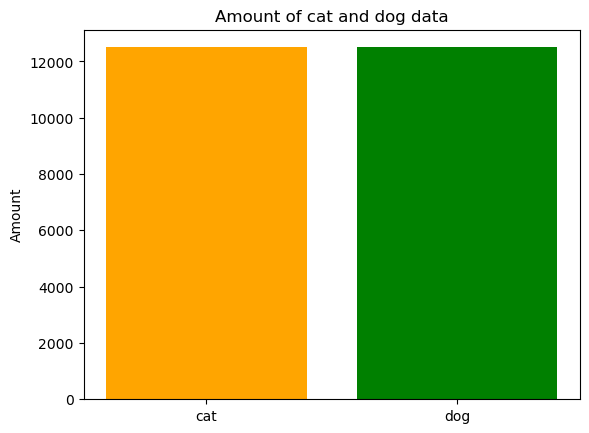

In [4]:
import os
import glob
import numpy as np
from PIL import Image

train_dir = os.path.join(constant.DATASET_DIR, 'train')
dict_lables = {"cat": 0, "dog": 1}
size = (64, 64)
data = []
label = []


def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = dict_lables[category]
        img = load_img(os.path.join(path, p), color_mode="grayscale")  # 圖片灰階
        img = img.resize(size, Image.Resampling.BILINEAR) # Pillow 10.0 use Image.Resampling.BILINEAR instead of Image.BILINEAR
        x = img_to_array(img)
        data.append(x)
        label.append(category)


print(train_dir)
create_test_data(train_dir)
data = np.array(data)
label = np.array(label)

#印出貓狗資料數量長條圖
bar_values = {'cat': label.size - np.count_nonzero(label), 'dog': np.count_nonzero(label)}
plt.bar(bar_values.keys(), bar_values.values(), color=['orange', 'green'])
plt.title('Amount of cat and dog data')
plt.ylabel('Amount')
plt.savefig(os.path.join(constant.OUTPUT_DIR,'Amount_of_cats_and_dogs'),dpi=400)
plt.show()

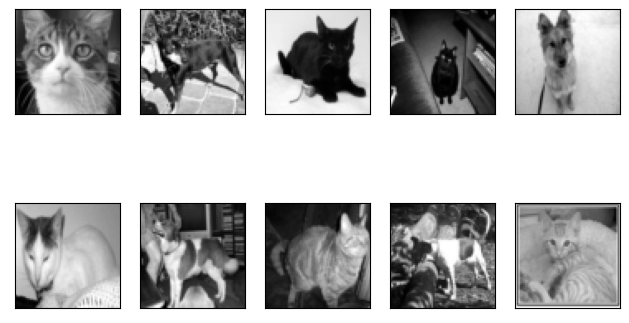

In [5]:
# 顯示部分處理後的圖片
import random

fig = plt.figure()

for i in range(1, 11):
    plt.subplot(2, 5, i)
    im = array_to_img(data[random.randint(0, data.shape[0])])
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

##### 處理圖片

重新定義尺寸和將處理好的陣列儲存，方便下次不用再次處理資料  
資料改變排列順序


In [6]:
import random

print('[Before reshape]:\ndata: {}\nlable:{}'.format(data.shape, label.shape))
data = np.array(data).reshape(-1, 64, 64, 1)
label = np.array(label)
print(f'\n[After Reshape]:\ndata: {data.shape}\nlabel: {label.shape}')

# Normalize Data(資料正規化)
# 我們在進行影像辨識時，我們在進行圖像預處理時，也會習慣將像素值縮放到[0,1]之間(即除以255)
data = data / 255.0

#資料重新排序(洗牌)
temp = list(zip(data, label))
random.shuffle(temp)
data, label = zip(*temp)
# 轉換回去array type
data = np.array(data)
label = np.array(label)

print('...Shuffle whole data and label done.')

# print(data)
# print(label)

# Save array in .npy file in data folder
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_data'), data)
np.save(os.path.join(constant.DATA_DIR, 'preprocessed_label'), label)
print('save preprocessed data done.')

[Before reshape]:
data: (25000, 64, 64, 1)
lable:(25000,)

[After Reshape]:
data: (25000, 64, 64, 1)
label: (25000,)
...Shuffle whole data and label done.
save preprocessed data done.


### 定義建立模型函數
> 定義建立cnn model函數

In [7]:
#定義建立cnn model函數
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=data.shape[1:]))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # Add a softmax layer with 10 output units:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### 訓練測試(含有callback)
[callback中文文檔](https://keras.io/zh/callbacks/#_1)
[其他參考資料](https://ithelp.ithome.com.tw/articles/10234641)

`TensorBoard`使用
> 開啟 cmd/終端機，執行 tensorboard --logdir=.\logs，啟動網頁伺服器，再使用瀏覽器輸入以下網址，即可觀看訓練資訊：
http://localhost:6006/

In [ ]:
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard

#load .npy file
data = np.load(os.path.join(constant.DATA_DIR, "preprocessed_data.npy"))
label = np.load(os.path.join(constant.DATA_DIR, "preprocessed_label.npy"))
print('Load preprocessed shuffled data completely.')

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

print("[Shape]:\ntrain data: {}\ntrain label: {}".format(train_data.shape, train_label.shape))
print("\ntest data: {}\ntest data label: {}".format(test_data.shape, test_label.shape))

#定義callback 函數
callbacks_list = [
    EarlyStopping(  #模型即時中斷點
        monitor='acc',  #監控accuracy
        patience=5  #5輪内不改善就中止
    ),
    ModelCheckpoint(  #模型存檔點
        filepath=constant.OUTPUT_DIR,  #輸出檔案路徑
        monitor='val_loss',  #監控validation loss
        save_best_only=True  #是否只保存最佳模型
    ),
    TensorBoard(
        log_dir='.\\log'
    )
]
model = create_cnn_model()
model.summary()

#model fit
history = model.fit(train_data, train_label, epochs=50, validation_split=0.2, callbacks=callbacks_list,
                    validation_freq=1)



#### 切割資料集

切割為訓練集和測試集資料(8:2)
利用10-fold cross-validation做驗證([參考資料](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md))
[混淆矩陣參考](https://yanwei-liu.medium.com/python%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98-%E5%9B%9B-%E4%BD%BF%E7%94%A8scikit-learn%E9%80%B2%E8%A1%8C%E9%82%8F%E8%BC%AF%E8%BF%B4%E6%AD%B8%E5%88%86%E6%9E%90-a5769715015d)
> 將訓練資料集切成10等分，每次取9:1做訓練和測試
train_test_split() 所接受的變數其實非常單純，基本上為 3 項：『原始的資料』、『Seed』、『比例』
這邊設定訓練資料80%，測試資料20%
* 原始的資料：就如同上方的 data 一般，是我們打算切成 Training data 以及 Test data 的原始資料
* Seed： 亂數種子，可以固定我們切割資料的結果
* 比例：可以設定 train_size 或 test_size，只要設定一邊即可，範圍在 [0-1] 之間

In [ ]:
print(len(history.history))
print(histoy.history)

### 訓練模型和使用K-fold cross validation來驗證模型

In [33]:
import os
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold

#load .npy file
data = np.load(os.path.join(constant.DATA_DIR, "preprocessed_data.npy"))
label = np.load(os.path.join(constant.DATA_DIR, "preprocessed_label.npy"))
print('Load preprocessed shuffled data completely.')

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

print("[Shape]:\ntrain data: {}\ntrain label: {}".format(train_data.shape, train_label.shape))
print("\ntest data: {}\ntest data label: {}".format(test_data.shape, test_label.shape))

#切割訓練資料集10等分
KF = KFold(n_splits=10)  #k-cv 10

# 定義 per-fold score 陣列
acc_per_fold = []
loss_per_fold = []

#fold num
fold_no = 1

#定義callback 函數(first train not to use)
# callbacks_list = [
#     keras.callbacks.EarlyStopping(
#         monitor='accuracy',  #监控精度
#         patience=5,  #5轮内不改善就中止
#     ),
#     keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(constant.OUTPUT_DIR, f'model_{fold_no}.h5')  #模型保存路径
#     monitor = 'val_loss',  #检测验证集损失值
# save_best_only = True  #是否只保存最佳模型
# )
# ]

# k-fold loop
for train_index, validation_index in KF.split(train_data):
    # 建立cnn模型
#     model = create_cnn_model()
    # 打印出來
    print('\n-------------------------------------------------------------------------')
    print(f'Training for fold: {fold_no}')
    
    # model fit (f_=fold)
    f_train_data, f_validation_data = train_data[train_index], train_data[validation_index]
    f_train_label, f_validation_label = train_label[train_index], train_label[validation_index]
    history = model.fit(f_train_data, f_train_label, epochs=50, validation_data=(f_validation_data, f_validation_label))

    # 儲存歷史紀錄和model
    folder = os.path.join(constant.OUTPUT_DIR,f'fold_{fold_no}')
    os.mkdir(folder)
    os.chdir(folder)
    history = pd.DataFrame.from_dict(history.history, orient='index').T
    history.to_excel(f'loss_accuracy_data_{fold_no}.xlsx', sheet_name='sheet1', index=False)
    history.to_pickle(f'loss_accuracy_data_{fold_no}.pkl')
    model.save(f"catdog_model_{fold_no}.h5")

    # Increase fold number
    fold_no = fold_no + 1


Load preprocessed shuffled data completely.
[Shape]:
train data: (20000, 64, 64, 1)
train label: (20000,)

test data: (5000, 64, 64, 1)
test data label: (5000,)

-------------------------------------------------------------------------
Training for fold: 1
Epoch 1/50
563/563 [==============================] - 3s 6ms/step - loss: 0.4346 - accuracy: 0.7979 - val_loss: 0.4869 - val_accuracy: 0.7640
Epoch 2/50
563/563 [==============================] - 3s 6ms/step - loss: 0.3945 - accuracy: 0.8210 - val_loss: 0.4850 - val_accuracy: 0.7735
Epoch 3/50
563/563 [==============================] - 3s 6ms/step - loss: 0.3435 - accuracy: 0.8491 - val_loss: 0.4740 - val_accuracy: 0.7800
Epoch 4/50
563/563 [==============================] - 3s 6ms/step - loss: 0.2966 - accuracy: 0.8726 - val_loss: 0.5226 - val_accuracy: 0.7720
Epoch 5/50
563/563 [==============================] - 3s 6ms/step - loss: 0.2409 - accuracy: 0.9007 - val_loss: 0.5798 - val_accuracy: 0.7775
Epoch 6/50
563/563 [=============

### 打包Output並下載

In [67]:
import shutil
import constant

shutil.make_archive('/kaggle/working/output.zip', 'zip', constant.OUTPUT_DIR)
print('compress success!!')

compress success!!


### 載入pkl和model檔

In [7]:
import os
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
import constant

# 讀取模型, history的存檔
models = []
histories = []

os.chdir(constant.OUTPUT_DIR)

for fold_no in range(1,11):
    folder_dir = os.path.join(constant.OUTPUT_DIR,f'fold_{fold_no}')
    pkl_dir = os.path.join(folder_dir,f'loss_accuracy_data_{fold_no}.pkl')
    model_dir = os.path.join(folder_dir,f'catdog_model_{fold_no}.h5')
    print(pkl_dir)
    print(model_dir)
    train_history = pd.read_pickle(pkl_dir)
    histories.append(train_history)
    model = load_model(model_dir)
    models.append(model)
    

/kaggle/working/output/fold_1/loss_accuracy_data_1.pkl
/kaggle/working/output/fold_1/catdog_model_1.h5
/kaggle/working/output/fold_2/loss_accuracy_data_2.pkl
/kaggle/working/output/fold_2/catdog_model_2.h5
/kaggle/working/output/fold_3/loss_accuracy_data_3.pkl
/kaggle/working/output/fold_3/catdog_model_3.h5
/kaggle/working/output/fold_4/loss_accuracy_data_4.pkl
/kaggle/working/output/fold_4/catdog_model_4.h5
/kaggle/working/output/fold_5/loss_accuracy_data_5.pkl
/kaggle/working/output/fold_5/catdog_model_5.h5
/kaggle/working/output/fold_6/loss_accuracy_data_6.pkl
/kaggle/working/output/fold_6/catdog_model_6.h5
/kaggle/working/output/fold_7/loss_accuracy_data_7.pkl
/kaggle/working/output/fold_7/catdog_model_7.h5
/kaggle/working/output/fold_8/loss_accuracy_data_8.pkl
/kaggle/working/output/fold_8/catdog_model_8.h5
/kaggle/working/output/fold_9/loss_accuracy_data_9.pkl
/kaggle/working/output/fold_9/catdog_model_9.h5
/kaggle/working/output/fold_10/loss_accuracy_data_10.pkl
/kaggle/working/

### Model Evaluation(模型評估)& Test (測試)

畫出混淆矩陣：[數據轉型](https://blog.csdn.net/EricHenry/article/details/105200883)

In [8]:
import os
import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

#切割訓練資料集10等分
KF = KFold(n_splits=10)  #k-cv 10

#load .npy file to split data
data = np.load(os.path.join(constant.DATA_DIR, "preprocessed_data.npy"))
label = np.load(os.path.join(constant.DATA_DIR, "preprocessed_label.npy"))
print('Load preprocessed shuffled data completely.')

#切割訓練資料集和測試資料集8:2
train_data, test_data, train_label, test_label = train_test_split(
    data, label, test_size=0.2, random_state=42)

print("[Shape]:\ntrain data: {}\ntrain label: {}".format(train_data.shape, train_label.shape))
print("\ntest data: {}\ntest data label: {}".format(test_data.shape, test_label.shape))

print(f'models len:{len(models)}, histories len:{len(histories)}\n')


# model evaluate模型驗證
def model_evaluate():
    fold_no = 1
    for (train_index, validation_index),model in zip(KF.split(train_data), models):
        f_train_data, f_validation_data = train_data[train_index], train_data[validation_index]
        f_train_label, f_validation_label = train_label[train_index], train_label[validation_index]
        #print
        print(f'##### Evaluate fold {fold_no} ########################')
        score = model.evaluate(f_train_data,f_train_label,verbose=0)
        print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}\n')

        #add fold_no
        fold_no +=1
    
    
# model test(return y_pred)
predictions = []
test_label_as_list = list(map(int,test_label))

def model_test():
    for model in models:
        fold_predictions = model.predict(test_data)
        predictions_as_list = list(map(int,fold_predictions))
        print(f'pred ele type: {type(predictions_as_list[0])}, label ele type: {type(test_label_as_list[0])}')
        predictions.append(predictions_as_list)
        print(f'predictions len: {len(predictions)}')
        
        
def generate_confusion_matrix():
    for fold_predictions, model in zip(models,predictions):
        print(fold_predictions.shape)
        cm = confusion_matrix(test_label_as_list, predictions_as_list)

# model evalute and test
model_evaluate()
model_test()



Load preprocessed shuffled data completely.
[Shape]:
train data: (20000, 64, 64, 1)
train label: (20000,)

test data: (5000, 64, 64, 1)
test data label: (5000,)
models len:10, histories len:10

##### Evaluate fold 1 ########################
Test loss: 0.007857306860387325
Test accuracy: 0.9977222084999084

##### Evaluate fold 2 ########################
Test loss: 0.0006894028629176319
Test accuracy: 0.9999444484710693

##### Evaluate fold 3 ########################
Test loss: 0.0004006361705251038
Test accuracy: 0.9999444484710693

##### Evaluate fold 4 ########################
Test loss: 0.01980733871459961
Test accuracy: 0.9942777752876282

##### Evaluate fold 5 ########################
Test loss: 8.089510083664209e-05
Test accuracy: 0.9999444484710693

##### Evaluate fold 6 ########################
Test loss: 7.71713093854487e-05
Test accuracy: 0.9999444484710693

##### Evaluate fold 7 ########################
Test loss: 4.617653394234367e-05
Test accuracy: 0.9999444484710693

#####

### 繪製每個fold的混淆矩陣和產出所有數值報表

model.predict_classes() [[使用方法]](https://blog.csdn.net/tszupup/article/details/85275111)
損失函數使用[Cross-entropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class)  
[參考](https://scikit-learn.org/stable/modules/model_evaluation.html)

[[2393   45]
 [2064  498]]


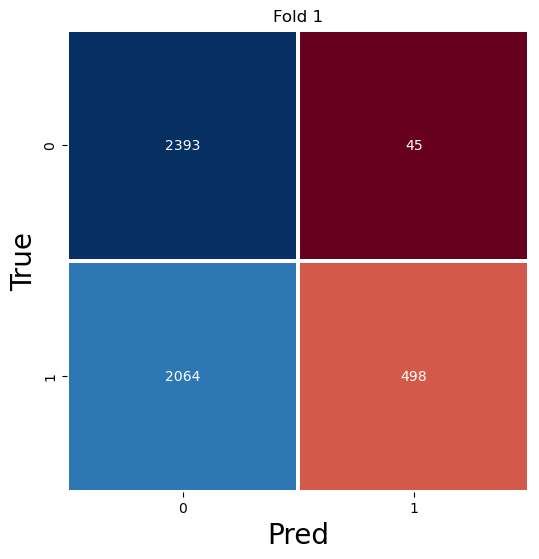

{'0': {'precision': 0.5369082342382768, 'recall': 0.9815422477440525, 'f1-score': 0.6941261783901378, 'support': 2438}, '1': {'precision': 0.9171270718232044, 'recall': 0.19437939110070257, 'f1-score': 0.3207729468599033, 'support': 2562}, 'accuracy': 0.5782, 'macro avg': {'precision': 0.7270176530307406, 'recall': 0.5879608194223775, 'f1-score': 0.5074495626250206, 'support': 5000}, 'weighted avg': {'precision': 0.7317323666167936, 'recall': 0.5782, 'f1-score': 0.5028199825540456, 'support': 5000}}
              precision    recall  f1-score    support
0              0.536908  0.981542  0.694126  2438.0000
1              0.917127  0.194379  0.320773  2562.0000
accuracy       0.578200  0.578200  0.578200     0.5782
macro avg      0.727018  0.587961  0.507450  5000.0000
weighted avg   0.731732  0.578200  0.502820  5000.0000
#####################################################################
[[2299  139]
 [1608  954]]


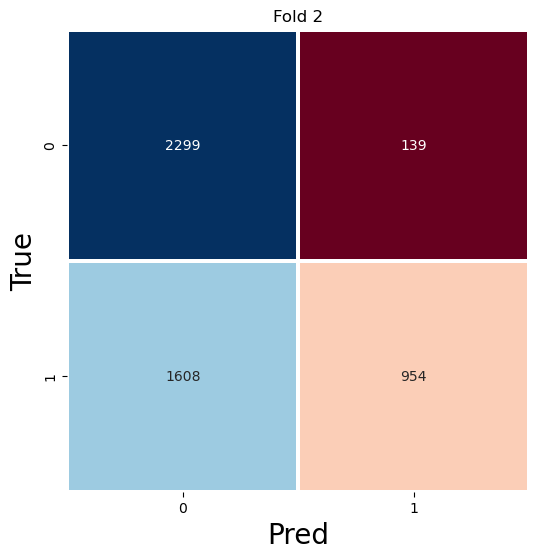

{'0': {'precision': 0.5884310212439212, 'recall': 0.94298605414274, 'f1-score': 0.7246650906225375, 'support': 2438}, '1': {'precision': 0.8728270814272644, 'recall': 0.37236533957845436, 'f1-score': 0.5220246238030095, 'support': 2562}, 'accuracy': 0.6506, 'macro avg': {'precision': 0.7306290513355929, 'recall': 0.6576756968605971, 'f1-score': 0.6233448572127736, 'support': 5000}, 'weighted avg': {'precision': 0.7341555624818662, 'recall': 0.6506, 'f1-score': 0.6208321154242115, 'support': 5000}}
              precision    recall  f1-score    support
0              0.588431  0.942986  0.724665  2438.0000
1              0.872827  0.372365  0.522025  2562.0000
accuracy       0.650600  0.650600  0.650600     0.6506
macro avg      0.730629  0.657676  0.623345  5000.0000
weighted avg   0.734156  0.650600  0.620832  5000.0000
#####################################################################
[[2318  120]
 [1642  920]]


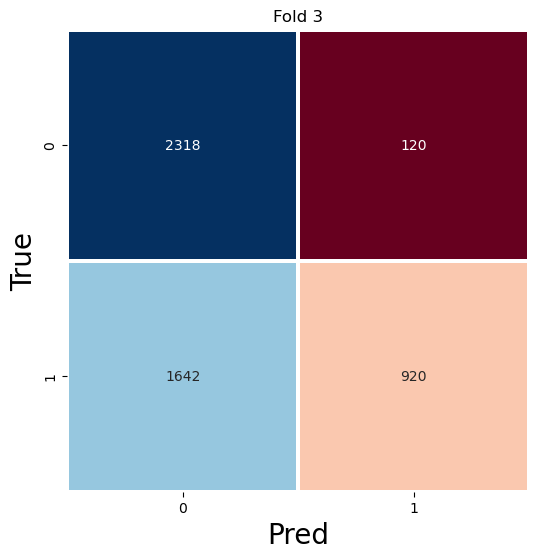

{'0': {'precision': 0.5853535353535354, 'recall': 0.9507793273174734, 'f1-score': 0.7246014379493593, 'support': 2438}, '1': {'precision': 0.8846153846153846, 'recall': 0.3590944574551132, 'f1-score': 0.5108273181565798, 'support': 2562}, 'accuracy': 0.6476, 'macro avg': {'precision': 0.7349844599844599, 'recall': 0.6549368923862933, 'f1-score': 0.6177143780529695, 'support': 5000}, 'weighted avg': {'precision': 0.7386953069153069, 'recall': 0.6476, 'f1-score': 0.615063578967539, 'support': 5000}}
              precision    recall  f1-score    support
0              0.585354  0.950779  0.724601  2438.0000
1              0.884615  0.359094  0.510827  2562.0000
accuracy       0.647600  0.647600  0.647600     0.6476
macro avg      0.734984  0.654937  0.617714  5000.0000
weighted avg   0.738695  0.647600  0.615064  5000.0000
#####################################################################
[[2229  209]
 [1430 1132]]


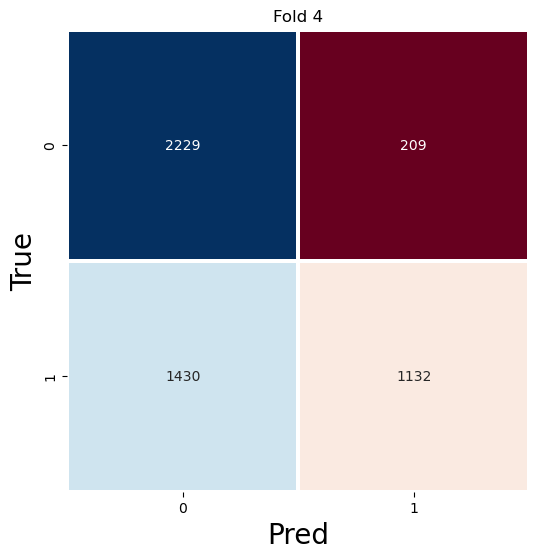

{'0': {'precision': 0.6091828368406669, 'recall': 0.9142739950779327, 'f1-score': 0.7311792684927013, 'support': 2438}, '1': {'precision': 0.8441461595824012, 'recall': 0.4418423106947697, 'f1-score': 0.5800666154240328, 'support': 2562}, 'accuracy': 0.6722, 'macro avg': {'precision': 0.726664498211534, 'recall': 0.6780581528863512, 'f1-score': 0.655622941958367, 'support': 5000}, 'weighted avg': {'precision': 0.7295780434135316, 'recall': 0.6722, 'f1-score': 0.6537491450603157, 'support': 5000}}
              precision    recall  f1-score    support
0              0.609183  0.914274  0.731179  2438.0000
1              0.844146  0.441842  0.580067  2562.0000
accuracy       0.672200  0.672200  0.672200     0.6722
macro avg      0.726664  0.678058  0.655623  5000.0000
weighted avg   0.729578  0.672200  0.653749  5000.0000
#####################################################################
[[2260  178]
 [1444 1118]]


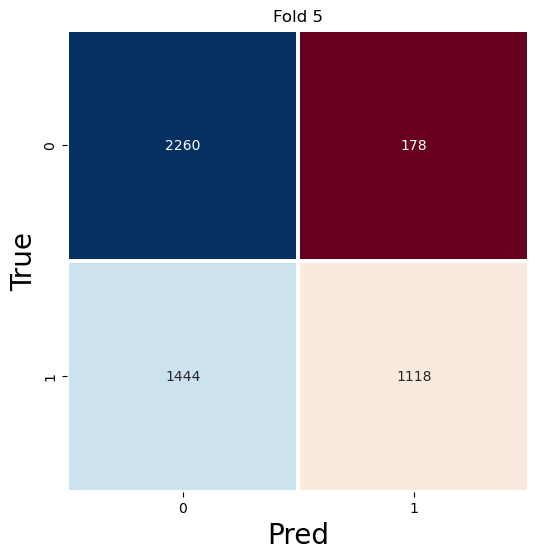

{'0': {'precision': 0.6101511879049676, 'recall': 0.9269893355209188, 'f1-score': 0.7359166395310974, 'support': 2438}, '1': {'precision': 0.8626543209876543, 'recall': 0.43637782982045276, 'f1-score': 0.5795749092794193, 'support': 2562}, 'accuracy': 0.6756, 'macro avg': {'precision': 0.736402754446311, 'recall': 0.6816835826706857, 'f1-score': 0.6577457744052584, 'support': 5000}, 'weighted avg': {'precision': 0.7395337932965362, 'recall': 0.6756, 'f1-score': 0.6558071369501376, 'support': 5000}}
              precision    recall  f1-score    support
0              0.610151  0.926989  0.735917  2438.0000
1              0.862654  0.436378  0.579575  2562.0000
accuracy       0.675600  0.675600  0.675600     0.6756
macro avg      0.736403  0.681684  0.657746  5000.0000
weighted avg   0.739534  0.675600  0.655807  5000.0000
#####################################################################
[[2191  247]
 [1204 1358]]


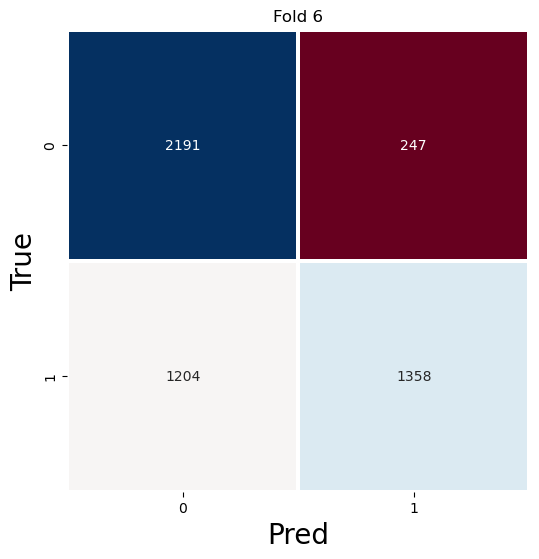

{'0': {'precision': 0.6453608247422681, 'recall': 0.898687448728466, 'f1-score': 0.7512429281673237, 'support': 2438}, '1': {'precision': 0.8461059190031153, 'recall': 0.5300546448087432, 'f1-score': 0.6517878569714423, 'support': 2562}, 'accuracy': 0.7098, 'macro avg': {'precision': 0.7457333718726917, 'recall': 0.7143710467686046, 'f1-score': 0.701515392569383, 'support': 5000}, 'weighted avg': {'precision': 0.7482226110415262, 'recall': 0.7098, 'f1-score': 0.7002821496865541, 'support': 5000}}
              precision    recall  f1-score    support
0              0.645361  0.898687  0.751243  2438.0000
1              0.846106  0.530055  0.651788  2562.0000
accuracy       0.709800  0.709800  0.709800     0.7098
macro avg      0.745733  0.714371  0.701515  5000.0000
weighted avg   0.748223  0.709800  0.700282  5000.0000
#####################################################################
[[2218  220]
 [1334 1228]]


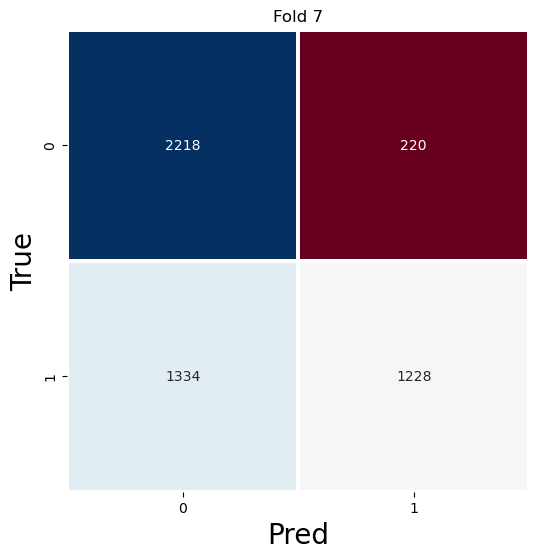

{'0': {'precision': 0.6244369369369369, 'recall': 0.9097621000820345, 'f1-score': 0.7405676126878129, 'support': 2438}, '1': {'precision': 0.8480662983425414, 'recall': 0.47931303669008585, 'f1-score': 0.6124688279301745, 'support': 2562}, 'accuracy': 0.6892, 'macro avg': {'precision': 0.7362516176397391, 'recall': 0.6945375683860602, 'f1-score': 0.6765182203089937, 'support': 5000}, 'weighted avg': {'precision': 0.7390246217211687, 'recall': 0.6892, 'f1-score': 0.674929795377999, 'support': 5000}}
              precision    recall  f1-score    support
0              0.624437  0.909762  0.740568  2438.0000
1              0.848066  0.479313  0.612469  2562.0000
accuracy       0.689200  0.689200  0.689200     0.6892
macro avg      0.736252  0.694538  0.676518  5000.0000
weighted avg   0.739025  0.689200  0.674930  5000.0000
#####################################################################
[[2168  270]
 [1116 1446]]


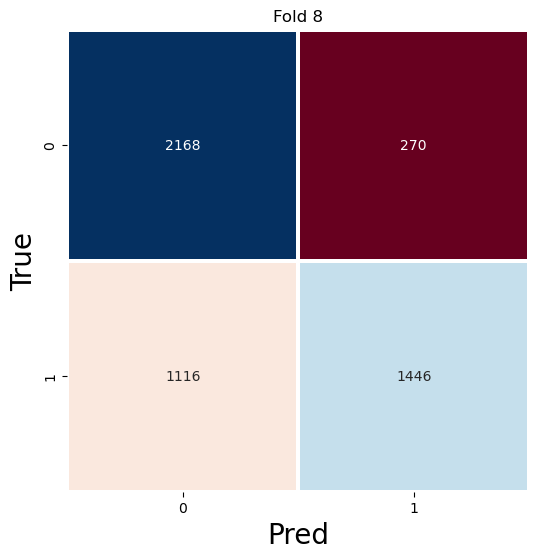

{'0': {'precision': 0.6601705237515225, 'recall': 0.889253486464315, 'f1-score': 0.7577770010485844, 'support': 2438}, '1': {'precision': 0.8426573426573427, 'recall': 0.5644028103044496, 'f1-score': 0.6760168302945302, 'support': 2562}, 'accuracy': 0.7228, 'macro avg': {'precision': 0.7514139332044326, 'recall': 0.7268281483843824, 'f1-score': 0.7168969156715572, 'support': 5000}, 'weighted avg': {'precision': 0.7536767697588648, 'recall': 0.7228, 'f1-score': 0.7158830895542071, 'support': 5000}}
              precision    recall  f1-score    support
0              0.660171  0.889253  0.757777  2438.0000
1              0.842657  0.564403  0.676017  2562.0000
accuracy       0.722800  0.722800  0.722800     0.7228
macro avg      0.751414  0.726828  0.716897  5000.0000
weighted avg   0.753677  0.722800  0.715883  5000.0000
#####################################################################
[[2248  190]
 [1393 1169]]


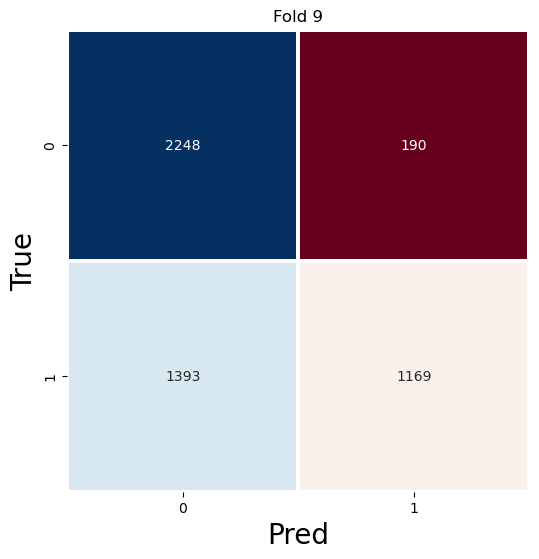

{'0': {'precision': 0.6174127986816809, 'recall': 0.9220672682526662, 'f1-score': 0.7395953281789769, 'support': 2438}, '1': {'precision': 0.8601913171449596, 'recall': 0.4562841530054645, 'f1-score': 0.5962764600867126, 'support': 2562}, 'accuracy': 0.6834, 'macro avg': {'precision': 0.7388020579133202, 'recall': 0.6891757106290654, 'f1-score': 0.6679358941328448, 'support': 5000}, 'weighted avg': {'precision': 0.7418125115422648, 'recall': 0.6834, 'f1-score': 0.6661587401685006, 'support': 5000}}
              precision    recall  f1-score    support
0              0.617413  0.922067  0.739595  2438.0000
1              0.860191  0.456284  0.596276  2562.0000
accuracy       0.683400  0.683400  0.683400     0.6834
macro avg      0.738802  0.689176  0.667936  5000.0000
weighted avg   0.741813  0.683400  0.666159  5000.0000
#####################################################################
[[2204  234]
 [1302 1260]]


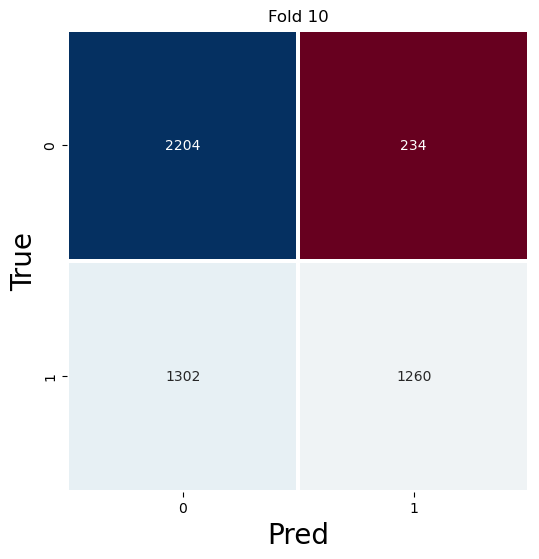

{'0': {'precision': 0.6286366229321164, 'recall': 0.904019688269073, 'f1-score': 0.7415881561238223, 'support': 2438}, '1': {'precision': 0.8433734939759037, 'recall': 0.4918032786885246, 'f1-score': 0.6213017751479291, 'support': 2562}, 'accuracy': 0.6928, 'macro avg': {'precision': 0.7360050584540101, 'recall': 0.6979114834787987, 'f1-score': 0.6814449656358756, 'support': 5000}, 'weighted avg': {'precision': 0.7386677956549531, 'recall': 0.6928, 'f1-score': 0.6799534145117746, 'support': 5000}}
              precision    recall  f1-score    support
0              0.628637  0.904020  0.741588  2438.0000
1              0.843373  0.491803  0.621302  2562.0000
accuracy       0.692800  0.692800  0.692800     0.6928
macro avg      0.736005  0.697911  0.681445  5000.0000
weighted avg   0.738668  0.692800  0.679953  5000.0000
#####################################################################
   fold     acc      loss  precision    recall  f1-score       auc    TP  \
0     1  0.5782  0.66

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import constant
import os
import pandas as pd
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score  

        
#  model.predict_classes() #放入img產出標籤
# make dir
fig_dir = os.path.join(constant.OUTPUT_DIR,'fig')
report_dir = os.path.join(constant.OUTPUT_DIR,'report')

#variables
r_accs = []
r_losses = []
r_precisions = []
r_recalls = []
r_f1_scores = []
r_aucs = []
r_TP = []
r_FN = []
r_FP = []
r_TN = []

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

if not os.path.exists(report_dir):
    os.mkdir(report_dir)
    
# save data
def save_fig(fold_no):
    plt.savefig(os.path.join(fig_dir,f'cm_{fold_no}'),dpi=400)
    

def save_report(fold_no, report):
    df = pd.DataFrame(report).transpose()
    
    #append precision,recall,f1-score
    marco_avg = df.loc['macro avg'] #使用macro avg
    r_precisions.append(marco_avg['precision'])
    r_recalls.append(marco_avg['recall'])
    r_f1_scores.append(marco_avg['f1-score'])
    
    print(df)
    df.to_csv(os.path.join(report_dir,f'report_{fold_no}.csv'), index=True)
    
    
for fold_no, fold_predictions, model in zip(range(1,11),predictions, models):
        cm = confusion_matrix(test_label_as_list, fold_predictions)
        print(cm)
        
        #turn to float type
        y_label = list(map(float,test_label_as_list)) 
        y_pred = list(map(float, fold_predictions))
       
        #calculate acc,loss,auc
        acc = accuracy_score(test_label_as_list, fold_predictions)
        loss = bce(y_label, y_pred).numpy() #使用cross-entropy
        fpr, tpr, _ = roc_curve(y_label, y_pred)    # 获得FPR、TPR值
        roc_auc = auc(fpr, tpr)    # 计算AUC值
        
        #append acc, loss, auc, TP, FN, FP,TN
        r_accs.append(acc)
        r_losses.append(loss)
        r_aucs.append(roc_auc)
        r_TP.append(cm[0][0])
        r_FN.append(cm[1][0])
        r_FP.append(cm[0][1])
        r_TN.append(cm[1][1])
        
        #show confusion matrix
        plt.figure(figsize=(6,6))
        sns.heatmap(cm,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
        plt.xlabel('Pred',fontsize=20)
        plt.ylabel('True',fontsize=20)
        plt.title(f'Fold {fold_no}')
        save_fig(fold_no)
        plt.show()
        

        #generate report
        report = classification_report(test_label_as_list, fold_predictions, output_dict=True)
        print(report)
        save_report(fold_no, report)
        print(f'#####################################################################')
    

# summary all folds and save to csv
df = pd.DataFrame({'fold':range(1,11),'acc':r_accs,'loss':r_losses,'precision':r_precisions,'recall':r_recalls,'f1-score':r_f1_scores,
                  'auc':r_aucs,'TP':r_TP,'FN':r_FN,'FP':r_FP,'TN':r_TN})
print(df)
df.to_csv(os.path.join(report_dir,f'summary_report_all_fold.csv'))

### 繪製圖表(訓練過程中的loss, val_loss, acc, val_acc)


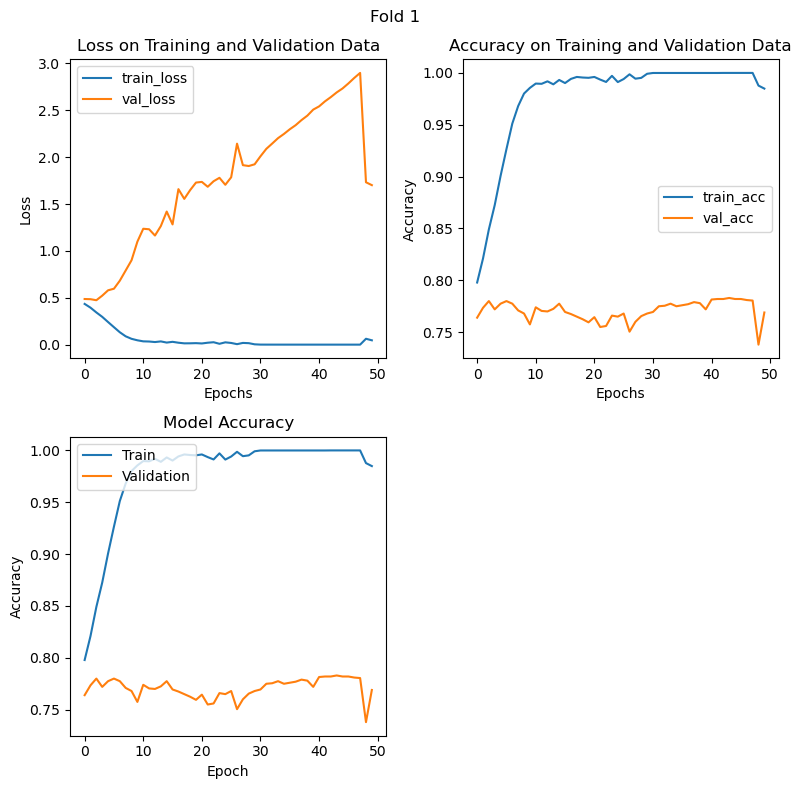

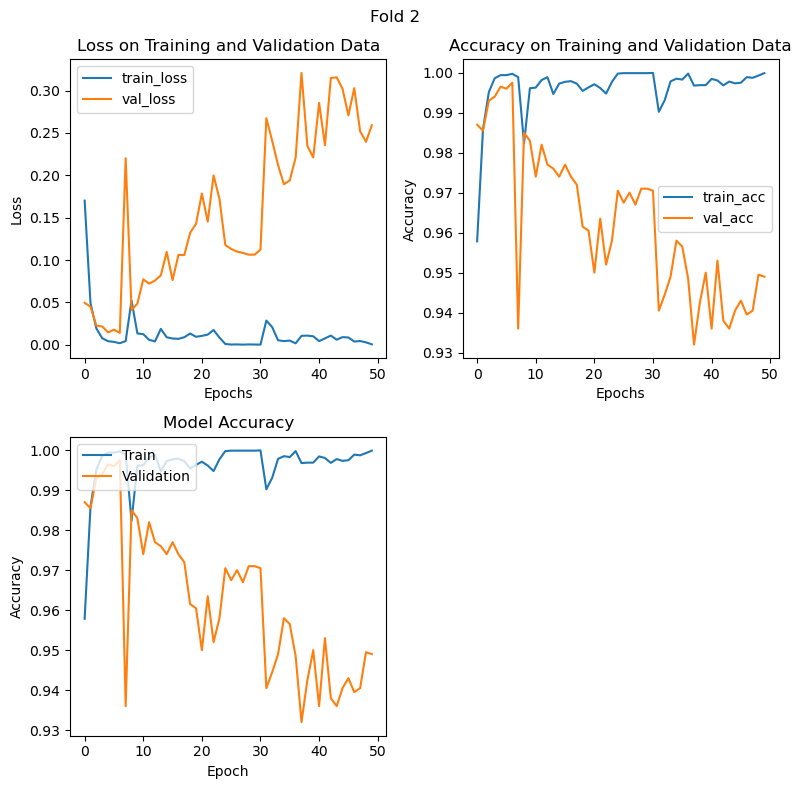

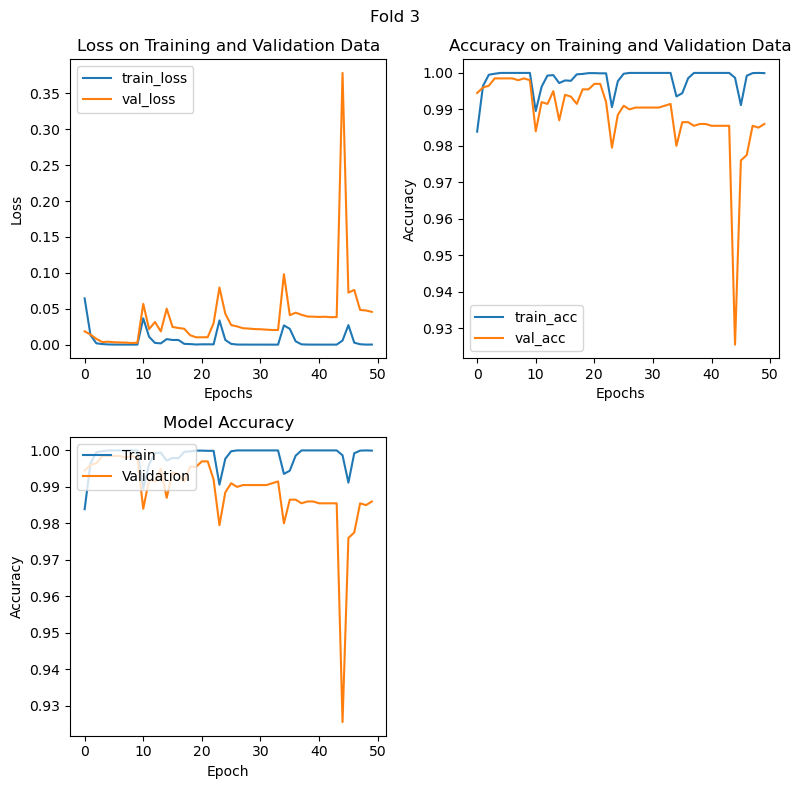

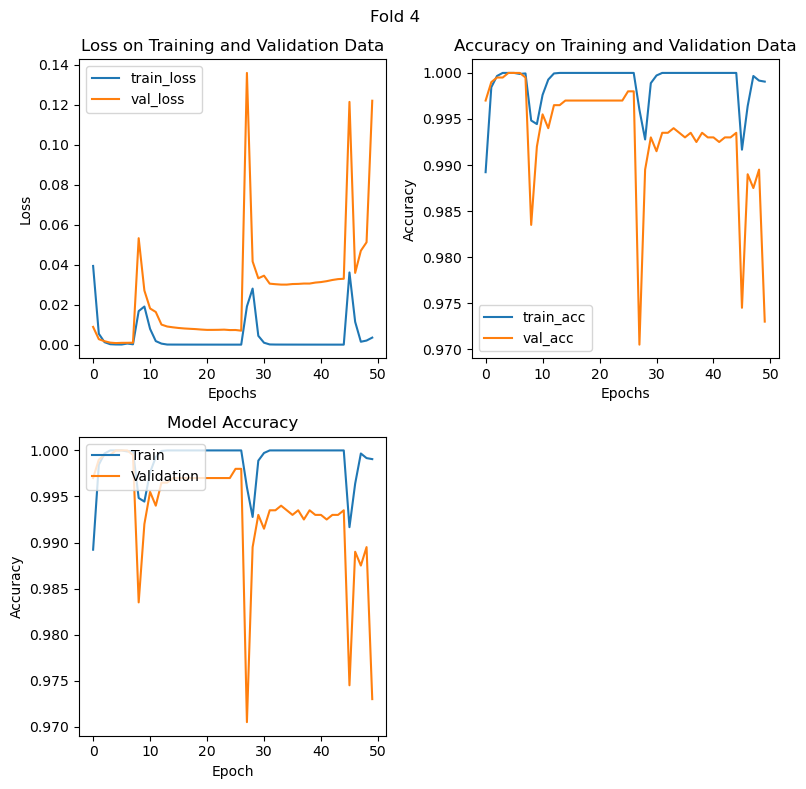

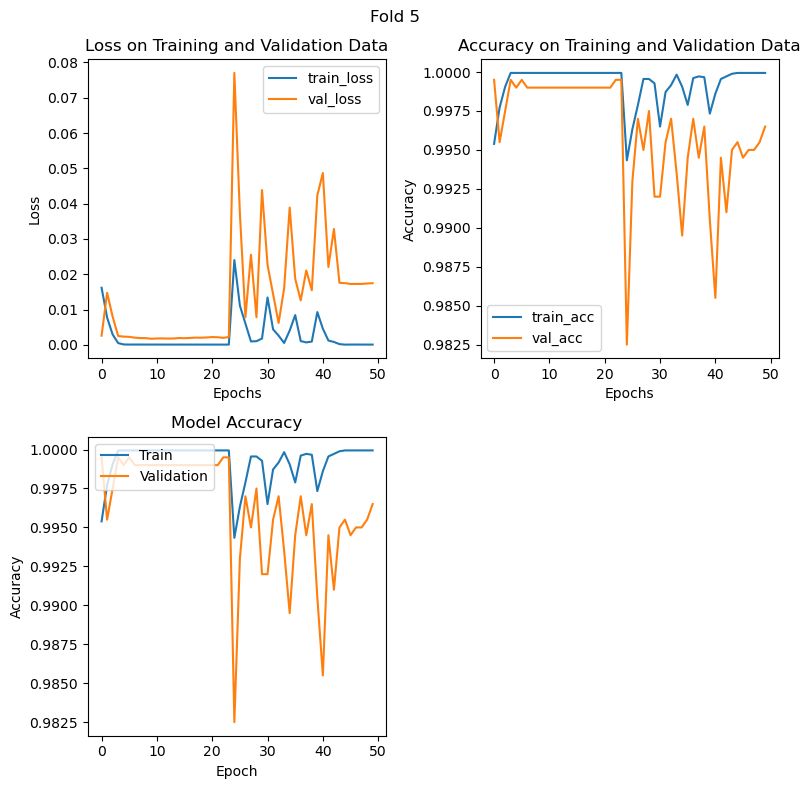

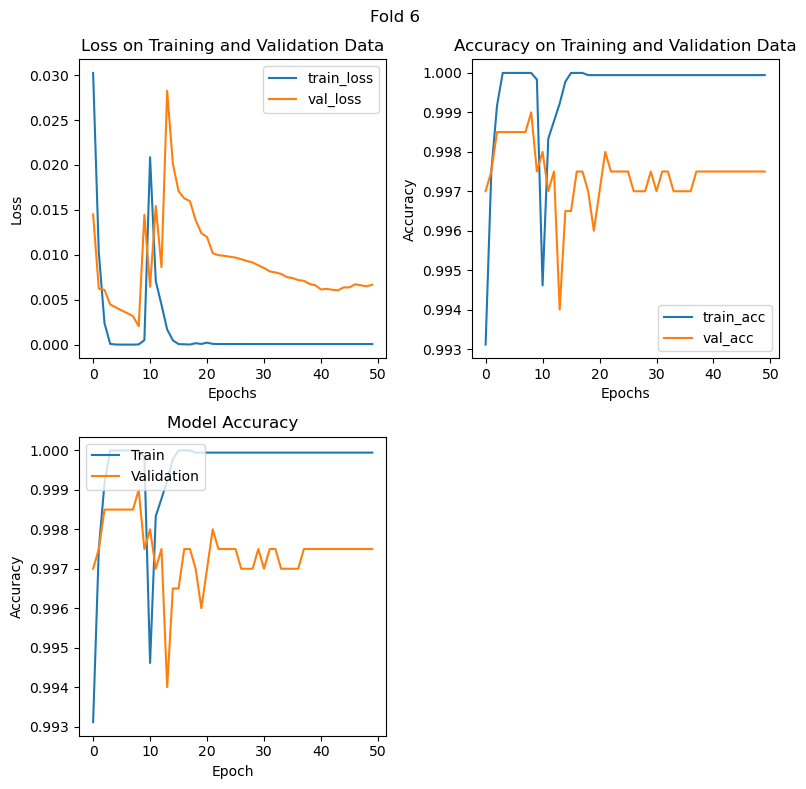

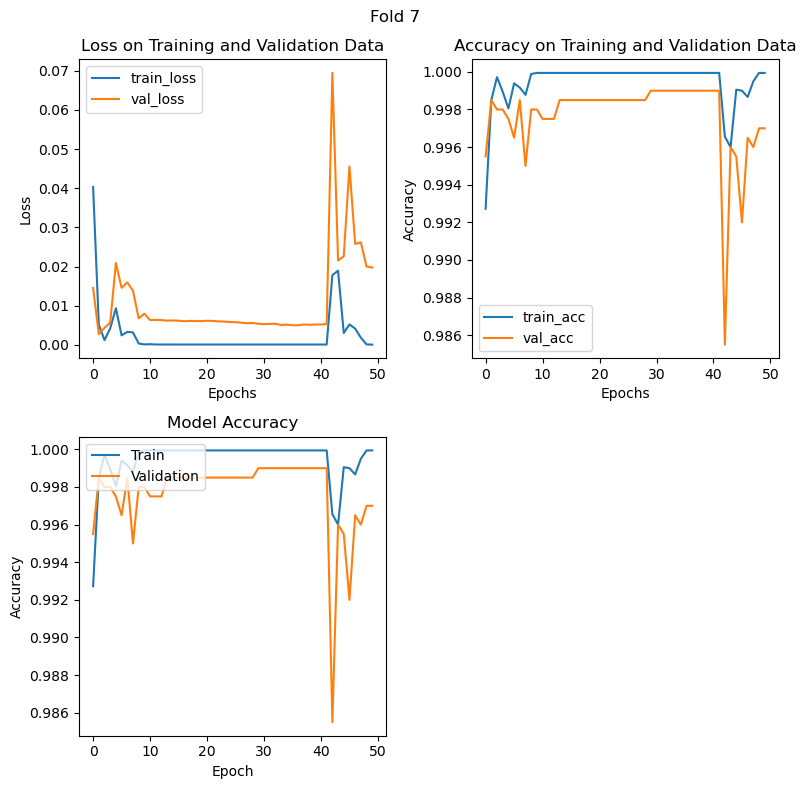

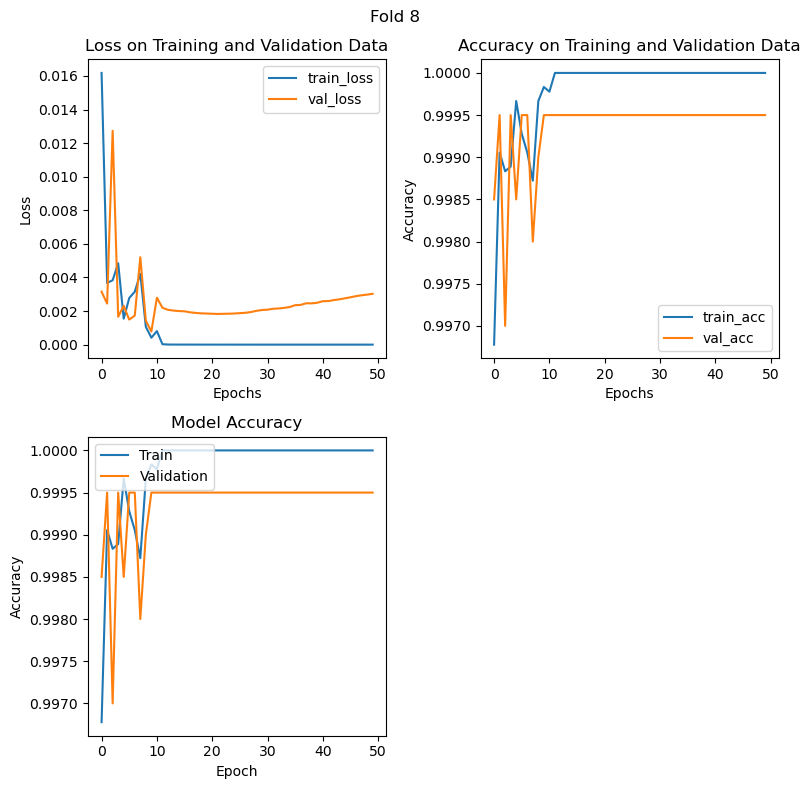

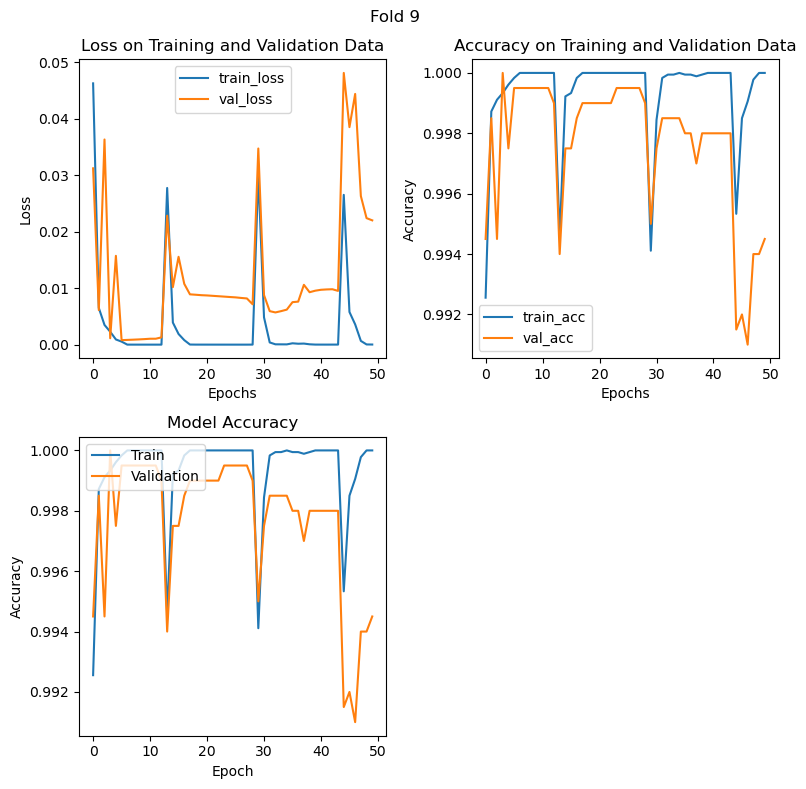

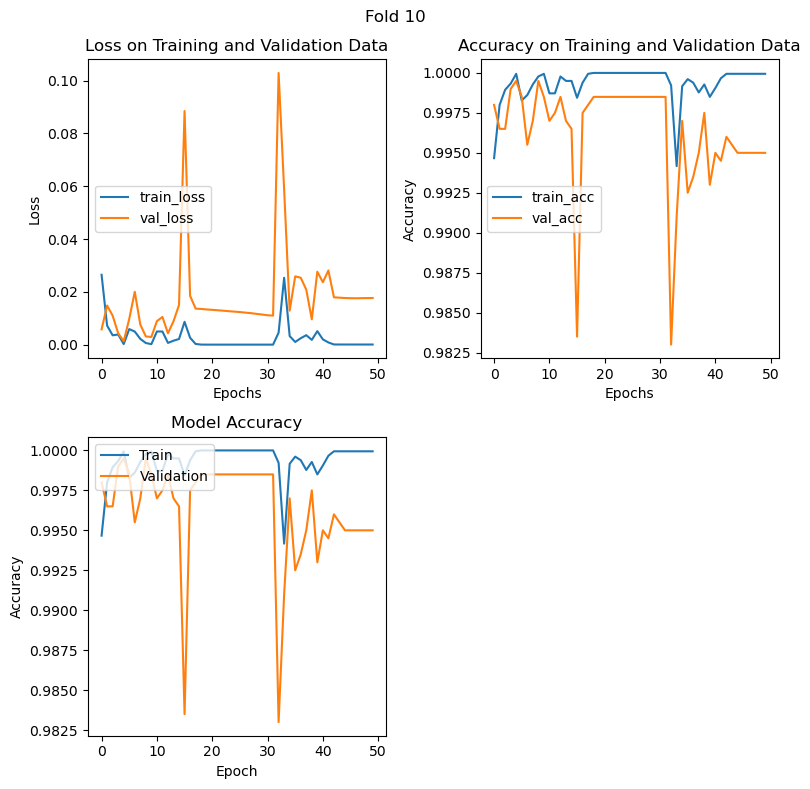

In [118]:
import matplotlib.pyplot as plt
import pickle
import os
import shutil
import constant

# make figure folder
fig_dir = os.path.join(constant.OUTPUT_DIR,'fig')
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)


def training_plot(_history, fold_no):
    loss = _history['loss']
    val_loss = _history['val_loss']
    acc = _history['accuracy']
    val_acc = _history['val_accuracy']

    #製作圖表
    fig = plt.figure(figsize=(8, 8))  #建立畫板(8*4英吋)
    # 描繪損失函數
    fig1 = fig.add_subplot(221)  # 一行兩列的第一個
    fig1.plot(loss, label='train_loss')
    fig1.plot(val_loss, label='val_loss')
    fig1.set_xlabel('Epochs')  #設定x軸
    fig1.set_ylabel('Loss')  #設定y軸
    fig1.set_title('Loss on Training and Validation Data')
    fig1.legend()  #給圖像加圖例
    # plt.show()

    # # subplot acc
    fig2 = fig.add_subplot(222)
    fig2.plot(acc, label='train_acc')
    fig2.plot(val_acc, label='val_acc')
    fig2.set_xlabel('Epochs')
    fig2.set_ylabel('Accuracy')
    fig2.set_title('Accuracy on Training and Validation Data')
    fig2.legend()  #給圖像加圖例

    plt.subplot(223)
    plt.plot(_history['accuracy'])
    plt.plot(_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')  #loc設置圖例位置
    plt.suptitle(f'Fold {fold_no}')
    plt.tight_layout()  #自動保持子圖的正確間距
    plt.savefig(os.path.join(fig_dir,f'loss_acc_fig_{fold_no}'),dpi=400)
    

for history,fold_no in zip(histories,range(1,11)):
    dict_history = history.to_dict(orient='list')
    training_plot(dict_history, fold_no)

# zip figure
shutil.make_archive('/kaggle/working/fig.zip', 'zip', fig_dir)
print('compress figure success!!')